# Intro to RL
Matteo Bunino - CERN openlab summer lectures 2024

#### Acknowledegments

- [Reinforcement Learning: an introduction](http://incompleteideas.net/book/the-book-2nd.html)
- [Gymnasium](https://gymnasium.farama.org/)
- [Felix Wagner's lecture](https://github.com/fewagner/icsc23/blob/main/1_mock_mdp.ipynb)
- DQN [tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- [Lunar Lander tutorial](https://github.com/Siddharth-2382/Lunar-Lander-AI/tree/main)
- [Catastrophic forgetting](https://stackoverflow.com/a/54238556) in Deep RL: why do we need target and policy networks?

In [1]:
# !pip install swig 1> /dev/null
# !pip install gymnasium[all] 1> /dev/null

import gymnasium as gym
from gymnasium import spaces
import numpy as np

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Markov Decision Process (MDP)

Let's consider the MDP depicted below 

<div>
<img src="img/MDP.png" width="500"/>
</div>

In [2]:
# p(s', r | s, a)
MDP_DYNAMICS = [
    # state 0
    [
        # action 0
        [
            # transition_probability, next_state, reward, terminal
            [0.5, 0, 0.0, False],
            [0.5, 2, 0.0, False],
        ],
        # action 1
        [
            [1.0, 2, 0.0, False]
        ]
    ],
    # state 1
    [
        # action 0
        [
            [0.7, 0, 5.0, False],
            [0.1, 1, 0.0, False],
            [0.2, 2, 0.0, False]
        ],
        # action 1
        [
            [0.95, 1, 0.0, False],
            [0.05, 2, 0.0, False]
        ]
    ],
    # state 2
    [
        # action 0
        [
            [0.4, 0, 0.0, False],
            [0.6, 2, 0.0, False]
        ],
        # action 1
        [
            [0.3, 0, -1.0, False],
            [0.3, 1, 0.0, False],
            [0.4, 2, 0.0, False],
        ]
    ]
]

# Inspect
state = 1
action = 0

MDP_DYNAMICS[state][action]

[[0.7, 0, 5.0, False], [0.1, 1, 0.0, False], [0.2, 2, 0.0, False]]

### 1.1 Defind MDP above as Gymnasium environment

In [3]:
class MDPEnv(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}
    NMBR_STATES = 3
    NMBR_ACTIONS = 2

    def __init__(self, seed: int = None):
        super(MDPEnv, self).__init__()
        self.rng = np.random.default_rng(seed)
        self.action_space = spaces.Discrete(self.NMBR_ACTIONS) 
        self.observation_space = spaces.Discrete(self.NMBR_STATES) 
        self.state = None
        self.P = MDP_DYNAMICS
        
    def step(self, action):
        
        info = {}
        truncated = False
        
        dynamics = np.array(self.P[self.state][action])
        _, new_state, reward, terminal = self.rng.choice(dynamics, p=dynamics[:, 0])
        new_state = int(new_state)
        terminal = bool(terminal)        
        self.state = new_state
        
        return new_state, reward, terminal, truncated, info
    
    def reset(self, state=None):
        info = {}
        if state is None:
            self.state = self.rng.integers(self.NMBR_STATES)
        else:
            self.state = state
        
        return self.state, info
        
    def render(self):
        print('Current state: ', self.state)

### 1.2 Explore the environment

In [4]:
env =  MDPEnv()

observation, info = env.reset()

# Let's perform 10 interactions with the environment
for _ in range(10):
    # Use a random policy
    action = np.random.randint(2)

    # Take action and print: next_state and reward
    observation, reward, terminal, truncated, info = env.step(action)
    print(observation, reward)

0 0.0
2 0.0
0 -1.0
2 0.0
2 0.0
0 0.0
2 0.0
1 0.0
1 0.0
1 0.0


Under the random policy, estimate the average return for each state:

1. Run $N$ episodes. starting from an initial random state
    1. For each episode, perform $T$ steps
    2. In the same episode, compute the returns for each state and average them
2. Average the state returns across all episodes

#### Definition of Return

<div>
<img src="img/return.png" width="500"/>
</div>
where $\gamma \in [0,1)$ is the discount factor and $R_t$ is the reward at step $t$.

<br><br>

Graphical representation:
<div>
<img src="img/return_graphics.png" width="800"/>
</div>

In [5]:
env =  MDPEnv()

gamma = 0.99
num_episodes = 20
T = 1000

global_state_returns = [[] for _ in range(env.NMBR_STATES)]
for _ in range(num_episodes):
    transitions = []
    # Reset to an initial random state
    state, _ = env.reset()
    
    # Run an episode
    for _ in range(T):
        # Use a random policy
        action = np.random.randint(2)
    
        # Take action
        next_state, reward, _, _, _ = env.step(action)

        # Record transition
        transitions.append((state, action, reward, next_state))
        state = next_state

    # Compute state returns
    state_returns = [[] for _ in range(env.NMBR_STATES)]
    g = 0
    # Unroll the episode from the end computing the rewards backwards
    for i, transition in enumerate(reversed(transitions)):
        state, action, reward, next_state = transition
        g = reward + g * gamma
        state_returns[state].append(g)
    
    # Average returns within this episode    
    for i in range(env.NMBR_STATES):
        state_returns[i] = np.mean(state_returns[i])
        global_state_returns[i].append(state_returns[i])

# Average returns across all episodes    
for i in range(env.NMBR_STATES):
    global_state_returns[i] = np.mean(global_state_returns[i])

global_state_returns

[17.372037114292233, 20.47899851588844, 17.68647063701739]

### 1.3 Policy evaluation: $V \approx v_\pi$

<div>
<img src="img/policy_eval.png" width="700"/>
</div>

From the "RL book" - chapt. 4

#### Evaluate the random policy

In [6]:
def policy_evaluation(env, policy, gamma, theta, v):
    """Compute state value function under the given policy.

    Args:
        env (MDPEnv): MDP environment.
        policy (np.ndarray): matrix for discrete policy with shape (NUM_ACTIONS, NUM_STATES). pi(a|s) = policy[a, s]
        gamma (float): discount factor.
        theta (float): aprroximation tolerance.
        v (np.ndarray): initial state values.

    Returns:
        np.ndarray: state values under the given policy.
    """
    num_actions, num_states = policy.shape
    delta = theta + 1
    while delta > theta:
        delta = 0    
        for s in range(num_states):
            old_v_s = v[s]
            new_v_s = 0
            for a in range(num_actions):
                transitions = env.P[s][a]
                for transition_prob, next_s, r, _ in transitions:
                    new_v_s += policy[a, s] * transition_prob * (r + gamma * v[next_s])
            
            delta = max(delta, np.abs(new_v_s - old_v_s))
            v[s] = new_v_s
    return v


# Define a random policy: pi(a|s) = pi[a, s]
policy = np.ones((env.NMBR_ACTIONS, env.NMBR_STATES)) / env.NMBR_ACTIONS
v = np.zeros(env.NMBR_STATES)
gamma = 0.99 # Discount factor
theta = 0.000001 # Tolerance

policy_evaluation(env, policy, gamma, theta, v)

array([20.18373883, 23.47744357, 20.45557502])

### 1.4 Value iteration

Let's find the optimal policy $\pi_*$

<div>
<img src="img/value_iteration.png" width="700"/>
</div>

From the "RL book" - chapt. 4

#### Compute the optimal policy

In [7]:
def value_iteration(env, gamma, theta, v, num_actions):
    """Compute the optimal policy.

    Args:
        env (MDPEnv): MDP environment.
        gamma (float): discount factor.
        theta (float): aprroximation tolerance.
        v (np.ndarray): initial state values.
        num_actions (int): dimensionality of action space.

    Returns:
        np.ndarray: matrix for discrete policy with shape (NUM_ACTIONS, NUM_STATES). pi(a|s) = policy[a, s]
    """
    num_states = len(v)
    delta = theta + 1
    while delta > theta:
        delta = 0    
        for s in range(num_states):
            old_v_s = v[s]
            new_v_s = 0
            vals_a = []
            for a in range(num_actions):
                transitions = env.P[s][a]
                val = 0
                for transition_prob, next_s, r, _ in transitions:
                    val += transition_prob * (r + gamma * v[next_s])
                vals_a.append(val)
            new_v_s = max(vals_a)
            delta = max(delta, np.abs(new_v_s - old_v_s))
            v[s] = new_v_s

    # Compute optimal greedy policy
    pi_star = np.zeros((num_actions, num_states))
    for s in range(num_states):
        vals_a = []
        for a in range(num_actions):
            transitions = env.P[s][a]
            val = 0
            for transition_prob, next_s, r, _ in transitions:
                val += transition_prob * (r + gamma * v[next_s])
            vals_a.append(val)
        a = np.argmax(vals_a)
        pi_star[a][s] = 1.0
    return pi_star

v = np.zeros(env.NMBR_STATES)
gamma = 0.99 # Discount factor
theta = 0.000001 # Tolerance

pi_star = value_iteration(env, gamma, theta, v, env.NMBR_ACTIONS)

print("pi*:\n", pi_star, '\n')

v_star = policy_evaluation(env, pi_star, gamma, theta, v)
print("V*: ", v_star)

pi*:
 [[0. 1. 0.]
 [1. 0. 1.]] 

V*:  [45.56054293 49.0405824  46.0207514 ]


## 2. Monte Carlo methods

### Epsilon-greedy policy

In [8]:
def argmax_break_ties(array, rng=None) -> int:
    """
    Argmax but breaks ties randomly.

    Args:
        array: 1-dimensional array.
        rng: random number generator. Defaul None.

    Returns:
        int: the argmax index in the input array.
    """
    curr_max = None
    max_candidates = []
    for idx, el in enumerate(array):
        if curr_max is None or el > curr_max:
            curr_max = el
            max_candidates = [idx]
        elif el == curr_max:
            max_candidates.append(idx)
        else:
            pass

    if rng is not None:
        return rng.choice(max_candidates)
    return np.random.choice(max_candidates)

def epsilon_greedy(state_values, epsilon: float) -> int:
    """
    Sample action using epsilon-greedy policy.

    Args:
        state_values: 1-dimensional array.
        epsilon (float): epsilon.

    Returns:
        int: the action ID.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(len(state_values))
    return argmax_break_ties(state_values)

# Test the epsilon_greedy action sampler
epsilon_greedy([1,1,1,1], epsilon=.9)

3

### 2.1 Implement the Monte Carlo control algorithm


<div>
<img src="img/mc_control.png" width="700"/>
</div>


In [9]:
def monte_carlo_control(env, gamma, epsilon, num_episodes, num_actions, v):
    """Monte Carlo control algorithm.

    Args:
        env (MDPEnv): MDP environment.
        gamma (float): discount factor.
        epsilon (float): epsilon for epsilon-greedy policy.
        num_episodes (int): number of episodes.
        num_actions (int): dimensionality of action space.
        v (np.ndarray): initial state values.

    Returns:
        np.ndarray: matrix for discrete policy with shape (NUM_ACTIONS, NUM_STATES). pi(a|s) = policy[a, s]
    """
    num_states = len(v)
    policy = np.ones((num_actions, num_states)) / num_actions
    n = np.zeros((num_actions, num_states))
    q = np.zeros((num_actions, num_states))
    rng = np.random.default_rng()
    for _ in range(num_episodes):
        # Generate an episode
        transitions = []
        state, _ = env.reset()
        for _ in range(1000):
            action = epsilon_greedy(q[:, state], epsilon)
            next_state, reward, terminal, _, _ = env.step(action)
            transitions.append((state, action, reward))
            state = next_state
            if terminal:
                break
        g = 0
        # Unroll the episode from the end computing the rewards backwards
        for i, transition in enumerate(reversed(transitions)):
            state, action, reward = transition
            g = reward + gamma * g
            n[action, state] += 1
            q[action, state] += (g - q[action, state]) / n[action, state]
        # Update policy
        for s in range(num_states):
            best_action = argmax_break_ties(q[:, s], rng)
            policy[:, s] = 0
            policy[best_action, s] = 1
    return policy

epsilon = 0.1

pi_star = monte_carlo_control(env, gamma, epsilon, num_episodes, env.action_space.n, v)

print("pi*:\n", pi_star, '\n')

v_star = policy_evaluation(env, pi_star, gamma, theta, v)
print("V*: ", v_star)

pi*:
 [[0. 1. 0.]
 [1. 0. 1.]] 

V*:  [45.56054388 49.04058335 46.02075234]


## 3. TD(0) methods

### 3.1 SARSA (on-polict TD control)

<div>
<img src="img/sarsa_control.png" width="700"/>
</div>

We will use the [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment.

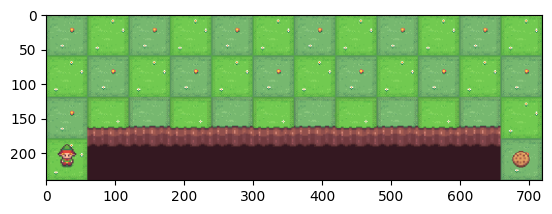

In [10]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()
img = plt.imshow(env.render())

In [11]:
env = gym.make("CliffWalking-v0")
q_table = np.zeros((env.observation_space.n, env.action_space.n))

In [12]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


#### Train the agent

Play around with the parameters below!

In [13]:
N_EPISODES = 10000
EPSILON = 0.1   # 10% of times take a random action
ALPHA = 0.1     # learing rate
GAMMA = 0.99    # discount factor

for _ in range(N_EPISODES):
    state, _ = env.reset()

    # Choose epsion-greedy action
    action = epsilon_greedy(q_table[state], epsilon=EPSILON)

    while True:
        next_state, reward, terminal, _, _ = env.step(action)
        if terminal:
            q_table[state][action] += ALPHA * (reward - q_table[state][action])
            break
        next_action = epsilon_greedy(q_table[next_state], epsilon=EPSILON)

        # Update Q-table
        q_table[state][action] += ALPHA * (reward + GAMMA * q_table[next_state][next_action] - q_table[state][action])

        # Record transition
        state = next_state
        action = next_action

In [14]:
sarsa_q_table = q_table
sarsa_q_table

array([[ -15.53563307,  -14.41128008,  -16.39669167,  -15.48677472],
       [ -14.4677199 ,  -13.53074465,  -14.97869104,  -15.61524034],
       [ -13.68063972,  -12.68210418,  -13.9146968 ,  -14.64330667],
       [ -12.55388108,  -11.79059936,  -13.0285003 ,  -13.674849  ],
       [ -11.815503  ,  -10.67617901,  -12.10273765,  -12.79729579],
       [ -10.54261007,   -9.59392691,  -11.07155415,  -11.8227521 ],
       [  -9.64883735,   -8.71824373,  -10.22527212,  -10.70375454],
       [  -8.64106665,   -7.56310715,   -9.30607523,  -10.31253794],
       [  -7.46990525,   -6.30924452,   -7.99981291,   -8.74673202],
       [  -6.45650106,   -5.44296723,   -6.88612545,   -7.63718915],
       [  -5.44999908,   -4.29298199,   -5.67769699,   -6.60273999],
       [  -4.70624719,   -4.45332293,   -3.32399562,   -5.82990603],
       [ -15.38165509,  -16.8378925 ,  -17.29372412,  -16.22997868],
       [ -14.5022356 ,  -14.47969302,  -28.9666488 ,  -15.85158964],
       [ -13.62765465,  -13.619412

#### Avoid the cliff!

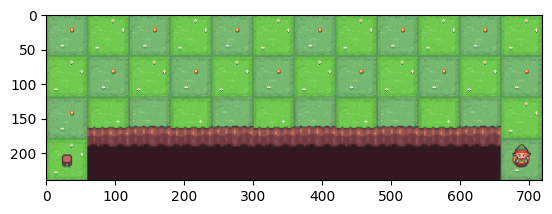

In [15]:
# Interact with the environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
state, _ = env.reset()
img = plt.imshow(env.render())

while True:
    # Choose a greedy action, not epsilon greedy
    action = np.argmax(sarsa_q_table[state])
    next_state, reward, terminal, _, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminal:
        break
    state = next_state
    action = np.argmax(sarsa_q_table[state])

### 3.2 Q-learning (off-polict TD control)

<div>
<img src="img/q_control.png" width="700"/>
</div>

Again,we will use the [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment.

In [16]:
env = gym.make("CliffWalking-v0")
q_table = np.zeros((env.observation_space.n, env.action_space.n))

In [17]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


#### Train the agent

Play around with the parameters below!

In [18]:
N_EPISODES = 1000
EPSILON = 0.1   # 10% of times take a random action
ALPHA = 0.1     # learing rate
GAMMA = 0.99    # discount factor

for _ in range(N_EPISODES):
    state, _ = env.reset()

    while True:
        # Choose epsion-greedy action
        action = epsilon_greedy(q_table[state], epsilon=EPSILON)
        
        next_state, reward, terminal, _, _ = env.step(action)
        if terminal:
            q_table[state][action] += ALPHA * (reward - q_table[state][action])
            break

        # Update Q-table
        max_q_next_state = np.max(q_table[next_state])
        q_table[state][action] += ALPHA * (reward + GAMMA * max_q_next_state - q_table[state][action])

        # Record transition
        state = next_state

In [19]:
qlearning_q_table = q_table
qlearning_q_table

array([[ -10.93883166,  -10.95439033,  -11.12057485,  -10.9831624 ],
       [ -10.57925151,  -10.5170859 ,  -10.58972059,  -10.5352971 ],
       [  -9.92175969,   -9.92466625,  -10.13108845,   -9.99093088],
       [  -9.22378625,   -9.21717639,   -9.27995396,   -9.59359306],
       [  -8.49487685,   -8.50030967,   -8.50277731,   -8.51557685],
       [  -7.8077526 ,   -7.77238058,   -7.82031919,   -7.78413643],
       [  -6.98916821,   -6.97929947,   -7.09363889,   -7.16883677],
       [  -6.19493354,   -6.17380884,   -6.25733426,   -6.39830978],
       [  -5.43035611,   -5.36513241,   -5.42029968,   -5.47949813],
       [  -4.66197008,   -4.5541109 ,   -4.56504293,   -4.67289377],
       [  -3.72169739,   -3.7377703 ,   -3.74342063,   -3.781702  ],
       [  -2.94300506,   -2.95012014,   -2.9280875 ,   -2.9979603 ],
       [ -11.41333647,  -11.38691588,  -11.43193325,  -11.43278093],
       [ -10.86250236,  -10.86586957,  -10.8838586 ,  -10.93820996],
       [ -10.19636842,  -10.170296

#### Avoid the cliff!

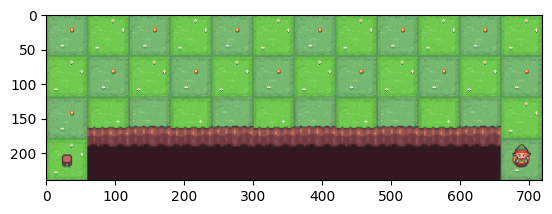

In [20]:
# Interact with the environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
state, _ = env.reset()
img = plt.imshow(env.render())

while True:
    # Choose a greedy action, not epsilon greedy
    action = np.argmax(qlearning_q_table[state])
    next_state, reward, terminal, _, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminal:
        break
    state = next_state

### 3.3 SARSA vs. Q-learning

Did you notice any differences between the behaviors of SARSA and Q-learning agents?

#### SARSA

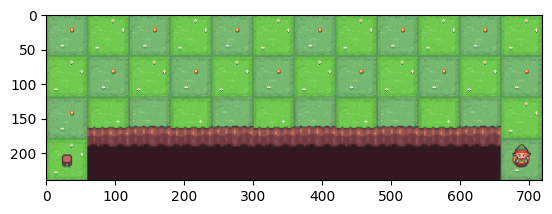

In [21]:
# SARSA
# Interact with the environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
state, _ = env.reset()
img = plt.imshow(env.render())

while True:
    # Choose a greedy action, not epsilon greedy
    action = np.argmax(sarsa_q_table[state])
    next_state, reward, terminal, _, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminal:
        break
    state = next_state
    action = np.argmax(sarsa_q_table[state])

#### Q-learning

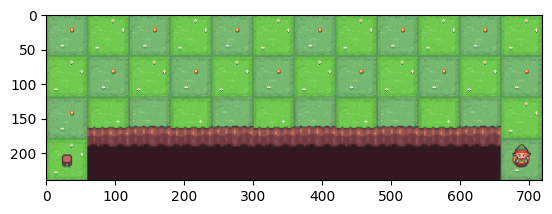

In [22]:
# Q-learning
# Interact with the environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
state, _ = env.reset()
img = plt.imshow(env.render())

while True:
    # Choose a greedy action, not epsilon greedy
    action = np.argmax(qlearning_q_table[state])
    next_state, reward, terminal, _, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminal:
        break
    state = next_state

#### Compare the rewards over time: SARSA vs. Q-learning

In [23]:
N_EPISODES = 1000
EPSILON = 0.1   # 10% of times take a random action
ALPHA = 0.1     # learing rate
GAMMA = 0.99    # discount factor

# SARSA
sarsa_rewards = []
env = gym.make("CliffWalking-v0")
q_table = np.zeros((env.observation_space.n, env.action_space.n))

for _ in range(N_EPISODES):
    state, _ = env.reset()
    tot_reward  = 0

    # Choose epsion-greedy action
    action = epsilon_greedy(q_table[state], epsilon=EPSILON)

    while True:
        next_state, reward, terminal, _, _ = env.step(action)
        tot_reward += reward
        
        if terminal:
            q_table[state][action] += ALPHA * (reward - q_table[state][action])
            break
        next_action = epsilon_greedy(q_table[next_state], epsilon=EPSILON)

        # Update Q-table
        q_table[state][action] += ALPHA * (reward + GAMMA * q_table[next_state][next_action] - q_table[state][action])

        # Record transition
        state = next_state
        action = next_action
    
    sarsa_rewards.append(tot_reward)

# Q-learning
qlearning_rewards = []
env = gym.make("CliffWalking-v0")
q_table = np.zeros((env.observation_space.n, env.action_space.n))

for _ in range(N_EPISODES):
    state, _ = env.reset()
    tot_reward = 0

    while True:
        # Choose epsion-greedy action
        action = epsilon_greedy(q_table[state], epsilon=EPSILON)
        
        next_state, reward, terminal, _, _ = env.step(action)
        tot_reward += reward

        if terminal:
            q_table[state][action] += ALPHA * (reward - q_table[state][action])
            break

        # Update Q-table
        max_q_next_state = np.max(q_table[next_state])
        q_table[state][action] += ALPHA * (reward + GAMMA * max_q_next_state - q_table[state][action])

        # Record transition
        state = next_state
    
    qlearning_rewards.append(tot_reward)

In [24]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

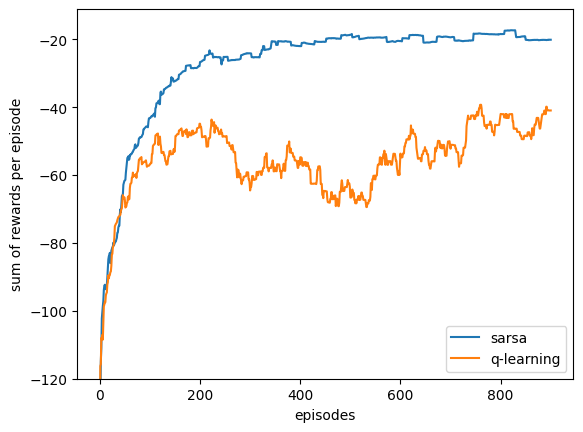

In [25]:
ax = plt.axes()
ax.plot(moving_average(sarsa_rewards, 100), label='sarsa')
ax.plot(moving_average(qlearning_rewards, 100), label='q-learning')
ax.set_ybound(-120)
ax.legend()
ax.set_ylabel("sum of rewards per episode")
ax.set_xlabel("episodes")
plt.show()

## 4. Q-learning with function approximation
We will use the [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment.

In [26]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque, namedtuple
import random

Initial state:  [-0.00281849  1.4147056  -0.2854995   0.16824579  0.00327272  0.06466984
  0.          0.        ]


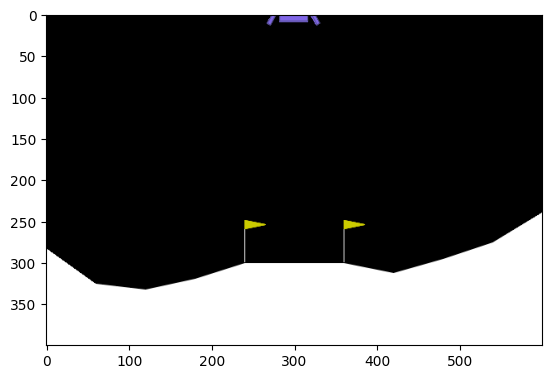

In [27]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
state, info = env.reset()
print("Initial state: ", state)

img = plt.imshow(env.render())

In [28]:
env.observation_space.shape, env.action_space

((8,), Discrete(4))

#### Define the neural network to estimate the value function

In [29]:
class QNet(nn.Module):
    def __init__(self, state_size: int, n_actions: int):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

Compute action values of state $S=(0,0,0,0,0,0,0,0)$ using randomly initialized (untrained) `QNet`:

In [30]:
model = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)
model(torch.zeros(1, env.observation_space.shape[0]))

tensor([[ 0.0086,  0.1570,  0.1219, -0.0267]], grad_fn=<AddmmBackward0>)

#### Replay memory

In [31]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, next_state, reward):
        """Save a transition"""
        self.memory.append(Transition(state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Check how `ReplayMemory` works:

In [32]:
replay_memory = ReplayMemory(2)

replay_memory.push(state=1, action=1, next_state=1, reward=1)
replay_memory.push(2, 2, 2, 2)

print(replay_memory.sample(2))

print("\nAfter exceeding memory size:")
replay_memory.push(3, 3, 3, 3)
replay_memory.push(4, 5, 6, 7)
print(replay_memory.sample(2))

[Transition(state=1, action=1, next_state=1, reward=1), Transition(state=2, action=2, next_state=2, reward=2)]

After exceeding memory size:
[Transition(state=3, action=3, next_state=3, reward=3), Transition(state=4, action=5, next_state=6, reward=7)]


#### Epsilon greedy policy

In [33]:
def epsilon_greedy_nn(state_values, policy_net: nn.Module, epsilon: float) -> int:
    """
    Sample action using epsilon-greedy policy with state values with function approximation.

    Args:
        state_values: 1-dimensional array.
        policy_net (nn.Module): torch neural network.
        epsilon (float): epsilon.

    Returns:
        int: the action ID.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(state_values.shape[0])
    with torch.no_grad():
        return policy_net(state).max(1).indices.item()

Get familiar with `policy_net` and $\epsilon$-greedy policies:

In [34]:
# Policy net
model = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)

state, info = env.reset()
state = torch.tensor(state).unsqueeze(0)
print("State: ", state)

# Proportional to the 
print("Action values: ", model(state))

# Force greedy action (epsilon = 0)
epsilon_greedy_nn(state, policy_net=model, epsilon=0)

# Does the greedy action correspond with the index of the highest action value?

State:  tensor([[ 0.0044,  1.3988,  0.4458, -0.5379, -0.0051, -0.1010,  0.0000,  0.0000]])
Action values:  tensor([[ 0.0940, -0.0432, -0.0739,  0.1280]], grad_fn=<AddmmBackward0>)


3

#### Compute the loss

In [35]:
def compute_loss(transitions_batch: Transition, policy_net: nn.Module, target_net: nn.Module):
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, transitions_batch.next_state)),
                                  dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in transitions_batch.next_state if s is not None])
    state_batch = torch.cat(transitions_batch.state)
    action_batch = torch.cat(transitions_batch.action)
    reward_batch = torch.cat(transitions_batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(-1))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    return loss

#### Train the agent

...but watch out for the **deadly triad** (RL book, Section 3.11)!

- off-policy learning: update $Q(s, a)$ using an action sampled fom a policy different from the exploration policy
- bootstrapping: approximate $G_t \approx R_{t+1} + \gamma Q(S_{t+1}, a)$, for some $a$.
- function approximation: learn a parametric version $Q(s, a ; \mathbf{w})$ of the value function, with parameters $\mathbf{w}$ .

which makes training *unstable*.

In [36]:
# Hyperparameters
MEMORY_SIZE = 100_000          # size of replay buffer
GAMMA = 0.995                  # discount factor
epsilon = 0.99                 # control randomness in epsilon-greedy policies
ALPHA = 1e-3                   # learning rate
LEARN_EVERY = 4                # perform a learning update every C time steps
NUM_EPISODES = 1000            # number of independent episodes
BATCH_SIZE = 128               # minibatch size for backpropagation
MAX_EPISODE_LENGTH = 2000      # max episode length
TAU = 0.001                    # controls soft update of policy net parameters
E_DECAY = 0.995                # ε-decay rate for the ε-greedy policy.
E_MIN = 0.01                   # minimum ε value for the ε-greedy policy.

env = gym.make('LunarLander-v2')

replay_memory = ReplayMemory(MEMORY_SIZE)

policy_net = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)
target_net = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)
# Copy weights
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=ALPHA)

In [37]:
episodes_reward = []
episodes_length = []
epsilons = []
tot_steps = 0
num_p_av=100
best_reward = 200
for ep in range(NUM_EPISODES):
    epsilons.append(EPSILON)
    
    tot_reward = 0
    episode_length = 0
    state, info = env.reset()
    state = torch.tensor(state).unsqueeze(0)
    for _ in range(MAX_EPISODE_LENGTH):
        # Choose action
        action = epsilon_greedy_nn(state, policy_net=policy_net, epsilon=EPSILON)
        
        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # Record transition
        tot_reward += reward
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state).unsqueeze(0)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        replay_memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Optimize the QNet
        if len(replay_memory) >= BATCH_SIZE and tot_steps % LEARN_EVERY == 0:
            transitions_batch = replay_memory.sample(BATCH_SIZE)
            # Transpose the tuples
            transitions_batch = Transition(*zip(*transitions_batch))

            loss = compute_loss(transitions_batch, policy_net, target_net)

            optimizer.zero_grad()
            loss.backward()
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            optimizer.step()
            
            # NEW
            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

        tot_steps += 1

        if terminated or truncated:
            episode_length += 1
            break
        episode_length += 1
    
    # Decaying epsilon
    EPSILON=max(E_MIN, E_DECAY * EPSILON)

    episodes_length.append(episode_length)
    episodes_reward.append(tot_reward)
    
    av_latest_points = np.mean(episodes_reward[-num_p_av:])
    
    print(f"\rEpisode {ep+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")
    if (ep+1) % num_p_av == 0:
        print(f"\rEpisode {ep+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    if av_latest_points > best_reward:
        # Save model
        torch.save(policy_net.state_dict(), "QNet_weights.pth")
        best_reward = av_latest_points

Episode 100 | Total point average of the last 100 episodes: -214.29
Episode 200 | Total point average of the last 100 episodes: -76.806
Episode 300 | Total point average of the last 100 episodes: -111.96
Episode 400 | Total point average of the last 100 episodes: -92.895
Episode 500 | Total point average of the last 100 episodes: 39.408
Episode 600 | Total point average of the last 100 episodes: 175.30
Episode 700 | Total point average of the last 100 episodes: 211.63
Episode 800 | Total point average of the last 100 episodes: 231.36
Episode 900 | Total point average of the last 100 episodes: 245.42
Episode 1000 | Total point average of the last 100 episodes: 246.13


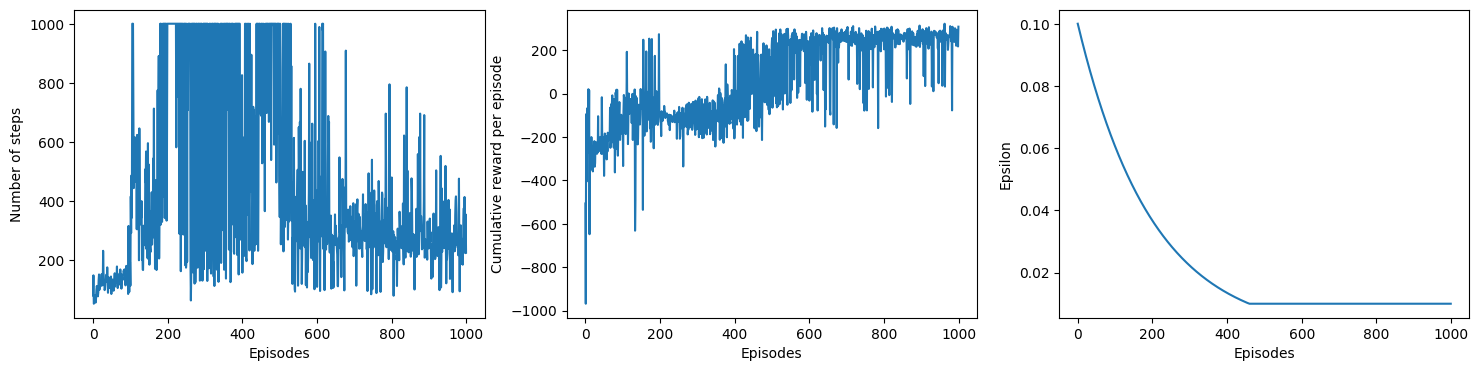

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(episodes_length)
ax[0].set_xlabel("Episodes")
ax[0].set_ylabel("Number of steps")

ax[1].plot(episodes_reward)
ax[1].set_xlabel("Episodes")
ax[1].set_ylabel("Cumulative reward per episode")

ax[2].plot(epsilons)
ax[2].set_xlabel("Episodes")
ax[2].set_ylabel("Epsilon")
plt.show()

#### Let's see the trained agent in action

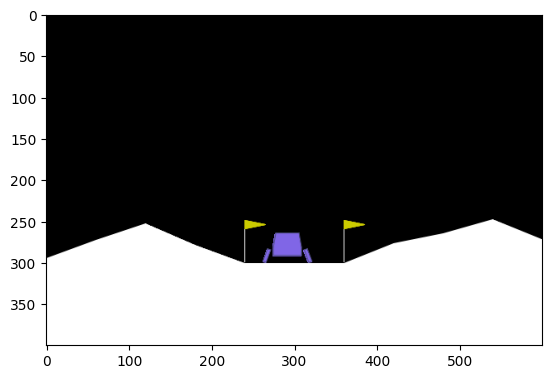

In [39]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
state, info = env.reset()
img = plt.imshow(env.render())

# Load model weights
policy_net = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)
policy_net.load_state_dict(torch.load("QNet_weights_best.pth"))

state, info = env.reset()
state = torch.tensor(state).unsqueeze(0)
while True:
    # Choose action
    action = epsilon_greedy_nn(state, policy_net=policy_net, epsilon=0)
    
    # Take action
    next_state, reward, terminated, truncated, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if terminated or truncated:
        break
    else:
        next_state = torch.tensor(next_state).unsqueeze(0)

    # Move to the next state
    state = next_state

#### Let's add some wind!

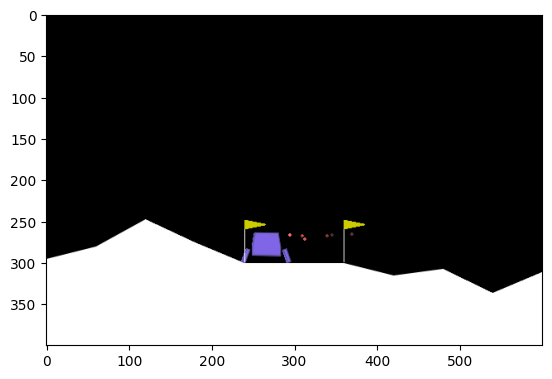

In [41]:
WIND_POWER=10

env = gym.make('LunarLander-v2', render_mode='rgb_array', enable_wind=True, wind_power=WIND_POWER)
state, info = env.reset()
img = plt.imshow(env.render())

# Load model weights
policy_net = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)
policy_net.load_state_dict(torch.load("QNet_weights_best.pth"))

state, info = env.reset()
state = torch.tensor(state).unsqueeze(0)
while True:
    # Choose action
    action = epsilon_greedy_nn(state, policy_net=policy_net, epsilon=0)
    
    # Take action
    next_state, reward, terminated, truncated, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if terminated or truncated:
        break
    else:
        next_state = torch.tensor(next_state).unsqueeze(0)

    # Move to the next state
    state = next_state